\newpage

# 0 Setup {-}

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    import tensorflow as tf

if IN_COLAB:
    %tensorflow_version 1.13
else:
    assert tf.__version__ == "1.13.1"

# ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.13`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [3]:
print(tf.__version__)

1.15.0


In [0]:
# ignore tensorflow depreciation warnings
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

### 0.1 Visualizing the Dataset {-}

In [0]:
# given by the assignment
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data ["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx]/255.
        Target = Target[randIndx]
        trainData, trainTarget = Data[:15000], Target[:15000]
        validData, validTarget = Data[15000:16000], Target[15000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

\newpage

In [6]:
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
print(f"Training Data: {trainData.shape}\tTraining tagets: {trainTarget.shape}")
print(f"Validation Data: {validData.shape}\tValidation tagets: {validTarget.shape}")
print(f"Testing Data: {testData.shape}\tTesting tagets:{testTarget.shape}")

Training Data: (15000, 28, 28)	Training tagets: (15000,)
Validation Data: (1000, 28, 28)	Validation tagets: (1000,)
Testing Data: (2724, 28, 28)	Testing tagets:(2724,)


In [0]:
def plot(image, target, ax=None):
    ax = plt.gca() if ax == None else ax
    ax.imshow(image, cmap=plt.cm.gray)
    target_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    ax.set_title(target_names[target])
    # targets interger encoded from 0 to 9 corresponding to 'A' to 'J', respectively

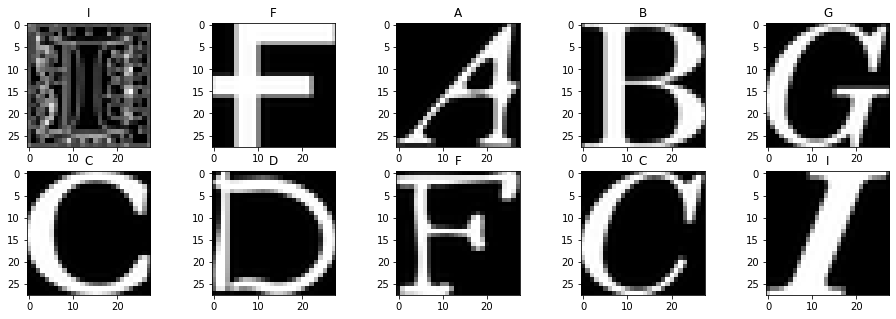

In [8]:
fig, axis = plt.subplots(2, 5, figsize=(16, 5))
for ax in axis.reshape(-1):
    r = np.random.randint(trainData.shape[0])
    plot(trainData[r], trainTarget[r], ax=ax)
plt.show()

\newpage

### 0.2 Useful Functions {-}

Some useful functions that will be used throughout the assignment such as getting random weights, getting the accuracy of a batch, making the loss and accuracy plots look nice, and global variables used throughout the code

In [0]:
# given by the assignment
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))
    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest

In [0]:
def accuracy(y_pred, y):
    if y_pred.shape != y.shape:
        raise ValueError(f"prediction dimension {y_pred.shape} and label dimensions {y.shape} don't match")
    return np.sum(y_pred.argmax(axis=1) == y.argmax(axis=1)) / y.shape[0]

In [0]:
def plot_loss(x, train_loss=None, valid_loss=None, test_loss=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_loss != None:
        ax.plot(x, train_loss, label="Training Loss")
    if valid_loss != None:
        ax.plot(x, valid_loss, label="Validation Loss")
    if test_loss != None:
        ax.plot(x, test_loss, label="Testing Loss")
    
    ax.set_title("Loss" if title == None else title)
    
    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Loss")
    ax.set_ylim(bottom=0)
    ax.legend(loc="upper right")

def plot_accuracy(x, train_accuracy=None, valid_accuracy=None, test_accuracy=None, title=None, ax=None):
    ax = plt.gca() if ax == None else ax
    if train_accuracy != None:
        ax.plot(x, train_accuracy, label="Training Accuracy")
    if valid_accuracy != None:
        ax.plot(x, valid_accuracy, label="Validation Accuracy")
    if test_accuracy != None:
        ax.plot(x, test_accuracy, label="Testing Accuracy")
    
    ax.set_title("Accuracy" if title == None else title)

    ax.set_xlabel("Iterations")
    ax.set_xlim(left=0)
    ax.set_ylabel("Accuracy")
    ax.set_yticks(np.arange(0, 1.1, step=0.1))
    ax.grid(linestyle='-', axis='y')
    ax.legend(loc="lower right")
    

def display_statistics(train_loss=None, train_acc=None, valid_loss=None, valid_acc=None, 
                       test_loss=None, test_acc=None, num=True, plot=True):
    
    tl = "-" if train_loss is None else round(train_loss[-1], 4)
    ta = "-" if train_acc is None else round(train_acc[-1]*100, 2)
    vl = "-\t" if valid_loss is None else round(valid_loss[-1], 4)
    va = "-" if valid_acc is None else round(valid_acc[-1]*100, 2)
    sl = "-\t\t" if test_loss is None else round(test_loss[-1], 4)
    sa = "-" if test_acc is None else round(test_acc[-1]*100, 2)
    
    if num:
        print(f"Training loss: {tl}{'':.20s}\t\tTraining acc: {ta}{'%' if ta != '-' else ''}")
        print(f"Validation loss: {vl}{'':.20s}\tValidation acc: {va}{'%' if va != '-' else ''}")
        print(f"Testing loss: {sl}{'':.20s}\tTesting acc: {sa}{'%' if sa != '-' else ''}")
    
    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(18, 6))
        plot_loss(np.arange(0, len(train_loss), 1), train_loss, valid_loss, test_loss, ax=ax[0])
        plot_accuracy(np.arange(0, len(train_loss), 1), train_acc, valid_acc, test_acc, ax=ax[1])
        plt.show()
        plt.close()

In [0]:
TINY = 1e-20
newtrain, newvalid, newtest = convertOneHot(trainTarget, validTarget, testTarget)
VTDatasets = {"validData" : validData.reshape(validData.shape[0], -1), "validTarget" : newvalid,
              "testData" : testData.reshape(testData.shape[0], -1), "testTarget" : newtest}

N = trainData.shape[0]
d = trainData.shape[1] * trainData.shape[2]
K = 10

\newpage

# 1 Neural Networks using Numpy {-}
### 1.1 Helper Functions {-}

In [0]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    return np.exp(x) / np.exp(x).sum()

def softmax_batch(X):
    return np.exp(X) / np.exp(X).sum(axis=1, keepdims=True)

In [0]:
def computeLayer(X, W, b):
    return X @ W.T + b

In [0]:
# target is one-hot encoded
def averageCE(target, prediction):
    return -(target * np.log(prediction+TINY)).sum(axis=1).mean()

# target is one-hot encoded
def gradCE(target, predication):
    return predication - target

### 1.2 Backpropagation Derivation {-} 

#### Derivative of Softmax

$p_i = \texttt{softmax}(\textbf{o})_i = \frac{e^{o_i}}{\sum_{k=1}^K e^{o_k}}$

$\quad \quad \quad \text{if  } i \neq j$
$$\frac{\partial p_j}{\partial o_i} = \frac{0 \cdot \sum_{k=1}^K e^{o_k} - e^{o_i} \cdot e^{o_j}}{\left(\sum_{k=1}^K e^{o_k}\right)^2} = \boxed{- p_i \cdot p_j}$$

$\quad \quad \quad \text{if  } i = j$
$$\frac{\partial p_j}{\partial o_i} = \frac{e^{o_i} \cdot \sum_{k=1}^K e^{o_k} - e^{o_i} \cdot e^{o_j}}{\left(\sum_{k=1}^K e^{o_k}\right)^2} = \boxed{(1 - p_j) \cdot p_i}$$

#### Derivative of Softmax + Cross Entropy Loss

$L_{CE}(\textbf{y}, \textbf{p}) = -\sum_{k=1}^{K} y_k \log{p_k}$

$$ \frac{\partial L_{CE}}{\partial o_i} =  -\sum_{k=1}^{K} \frac{y_k}{p_k} \cdot \frac{\partial p_k}{\partial o_i} = -y_i(1 - p_i) - \sum_{k \neq i} \frac{y_k}{p_k} \cdot (-p_k p_i) = -y_i + y_ip_i + \sum_{k \neq i} y_k p_i = -y_i + p_i \cdot \sum_{k=1}^K y_k = p_i - y_i$$

In Vector Form: $\boxed{\frac{\partial L_{CE}}{\partial \textbf{o}} = \textbf{p} - \textbf{y}}$

#### Remaining Backpropogation

$\textbf{o} = W_o \textbf{g} + \textbf{b}_o$

$$\frac{\partial L}{\partial W_o} = \frac{\partial L}{\partial \textbf{o}} \cdot \left(\frac{\partial \textbf{o}}{\partial W_o}\right)^T = \frac{\partial L}{\partial \textbf{o}} \cdot \textbf{g}^T$$

$$\frac{\partial L}{\partial \textbf{b}_o} = \frac{\partial L}{\partial \textbf{o}} \cdot \left(\frac{\partial \textbf{o}}{\partial \textbf{b}_o}\right)^T = \frac{\partial L}{\partial \textbf{o}}$$

$g_i = \texttt{ReLU}(h_i) = \texttt{max}(h_i, 0)$

$$\frac{\partial L}{\partial h_i} = \frac{\partial L}{\partial g_i} \cdot \frac{\partial g_i}{\partial h_i} = \begin{cases} \frac{\partial L}{\partial g_i} &\text{if } h_i > 0 \\ 0 &\text{if } h_i < 0 \end{cases}$$

$\textbf{h} = W_h \textbf{x} + \textbf{b}_h$

$$\frac{\partial L}{\partial W_h} = \frac{\partial L}{\partial \textbf{h}} \cdot \left(\frac{\partial \textbf{h}}{\partial W_h}\right)^T = \frac{\partial L}{\partial \textbf{h}} \cdot \textbf{x}^T$$

$$\frac{\partial L}{\partial \textbf{b}_h} = \frac{\partial L}{\partial \textbf{h}} \cdot \left(\frac{\partial \textbf{h}}{\partial \textbf{b}_h}\right)^T = \frac{\partial L}{\partial \textbf{h}}$$

### 1.3 Learning {-}

epoch: 1
epoch: 2	loss: 41.8202	acc: 0.0623
epoch: 3	loss: 38.6344	acc: 0.1826
epoch: 4	loss: 30.5366	acc: 0.5814
epoch: 5	loss: 23.6037	acc: 0.6173
epoch: 6	loss: 20.7250	acc: 0.7061
epoch: 7	loss: 17.2101	acc: 0.7915
epoch: 8	loss: 19.0484	acc: 0.6860
epoch: 9	loss: 15.4555	acc: 0.7875
epoch: 10	loss: 13.4947	acc: 0.7948
epoch: 11	loss: 12.6952	acc: 0.7845
epoch: 12	loss: 12.3658	acc: 0.8017
epoch: 13	loss: 11.3749	acc: 0.8021
epoch: 14	loss: 9.8147	acc: 0.8311
epoch: 15	loss: 9.0415	acc: 0.8425
epoch: 16	loss: 8.4522	acc: 0.8576
epoch: 17	loss: 9.6073	acc: 0.8306
epoch: 18	loss: 8.6273	acc: 0.8579
epoch: 19	loss: 7.4822	acc: 0.8685
epoch: 20	loss: 7.6507	acc: 0.8607
epoch: 21	loss: 7.6104	acc: 0.8610
epoch: 22	loss: 7.3691	acc: 0.8727
epoch: 23	loss: 7.8118	acc: 0.8719
epoch: 24	loss: 7.4743	acc: 0.8791
epoch: 25	loss: 7.5346	acc: 0.8783
epoch: 26	loss: 7.4533	acc: 0.8836
epoch: 27	loss: 7.5341	acc: 0.8862
epoch: 28	loss: 7.8440	acc: 0.8823
epoch: 29	loss: 7.6133	acc: 0.8800
epoch: 

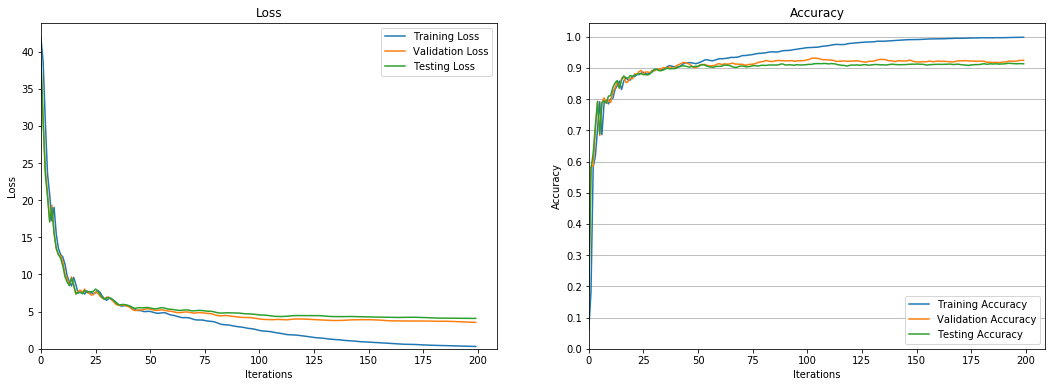

Time is 342.4068307876587.


In [16]:
class mini_NN(object):

    """ 
    Network Structure:
        input:  x
        hidden: h = W_h * x + b_h
                g = ReLU(h)
        output: o = W_o * g + b_o
                p = softmax(o)
    """

    def __init__(self, D, F, K):
        # D, F, and K are the number of neurons in the input, hidden, and output layers
        self.D = D
        self.F = F
        self.K = K
        self.init_weights()

    def init_weights(self):
        # getting random parameters using Xaiver initialization scheme
        self.W_h = np.random.normal(0, np.sqrt(2.0/(self.D+self.F)), (self.F, self.D))
        self.b_h = np.random.normal(0, np.sqrt(2.0/(self.D+self.F)), self.F) 
        self.W_o = np.random.normal(0, np.sqrt(2.0/(self.F+self.K)), (self.K, self.F))
        self.b_o = np.random.normal(0, np.sqrt(2.0/(self.F+self.K)), self.K)
    
    def feedforward(self, X):
        # python can dynamically create attributes
        self.H = computeLayer(X, self.W_h, self.b_h)
        self.G = relu(self.H)
        self.O = computeLayer(self.G, self.W_o, self.b_o)
        self.P = softmax_batch(self.O)
        return self.P
    
    def backpropagation(self, X, y):
        
        # This function assumes that feedforward was called before, 
        # which instantiates the needed activations
        
        # output layer activations
        dL_do = gradCE(y, self.P)

        # output layer parameters
        dL_dWo = dL_do.T @ self.G
        dL_dbo = dL_do

        # hidden layer activations
        dL_dg = dL_do @ self.W_o 
        dL_dh = dL_dg.copy()
        dL_dh[self.H <= 0] = 0

        # hidden layer parameters
        dL_dWh = dL_dh.T @ X
        dL_dbh = dL_dh
        
        return dL_dWo , dL_dbo.sum(axis=0), dL_dWh, dL_dbh.sum(axis=0)

    def train(self, X, y, epochs=200, gamma=0.99, alpha=1e-5, F=None,
              validData=None, validTarget=None, testData=None, testTarget=None):
        # initializations
        self.F = self.F if F is None else F
        self.init_weights()
        
        train_loss, train_acc = [], []
        valid_loss, valid_acc = [], []
        test_loss, test_acc = [], []
        
        v_Wo, v_Wh = 0, 0
        
        for e in range(epochs):
            if e > 0:
                print(f"epoch: {e+1}\tloss: {train_loss[-1]:.4f}\tacc: {train_acc[-1]:.4f}")
            else:
                print("epoch:", e+1)
            
            # getting predictions
            p = self.feedforward(X)
            train_loss.append( averageCE(p, y) )
            train_acc.append( accuracy(p, y) )
            
            # getting gradients
            dL_dWo, dL_dbo, dL_dWh, dL_dbh = self.backpropagation(X, y)
            
            # updating parameters
            v_Wo = gamma * v_Wo + alpha * dL_dWo
            self.W_o -= v_Wo
            
            self.b_o -= alpha * dL_dbo
            
            v_Wh = gamma * v_Wh + alpha * dL_dWh
            self.W_h -= v_Wh
            
            self.b_h -= alpha * dL_dbh
            
            # calculating statistics
            if not validData is None and not validTarget is None:
                p = self.feedforward(validData)
                valid_loss.append(averageCE(p, validTarget))
                valid_acc.append(accuracy(p, validTarget))
            if not testData is None and not testTarget is None:
                p = self.feedforward(testData)
                test_loss.append(averageCE(p, testTarget))
                test_acc.append(accuracy(p, testTarget))
        
        statistics = (train_loss, train_acc)
        if not validData is None and not validTarget is None:
            statistics += (valid_loss, valid_acc, )
        if not testData is None and not testTarget is None:
            statistics += (test_loss, test_acc,)
        return statistics

X = trainData.reshape(N, d)

y = newtrain

# For investigation, analyze how long each hyperparameter set takes to train
import time
start = time.time()

model = mini_NN(d, 1000, K)
statistics = model.train(X, y, epochs=200, gamma=0.99, alpha=1e-5, **VTDatasets)
display_statistics(*statistics)
print(f"Time is {time.time() - start}.")

### 1.4 Hyperparameter Investigation {-}

## Number of Hidden Units

### Number of hidden units: 100

|Statistic | Value | | Statistic | Value |
|:---|---:|---|:---|---:|
| Training loss:| 4.6824	|	|Training acc:|92.31%|
| Validation loss:| 5.5578	 |   |Validation acc:|89.8%|
| Testing loss:| 5.7423	 |  |Testing acc:|89.46%|
| Training Time(s):| 42.705

**Comments**: Accuracy seems to have converged by 50 iterations. Training this network with 100 hidden units was the fastest of the three. This is likely because there were very few parameters to optimize.

### Number of hidden units: 500

Statistic | Value | | Statistic | Value 
:---|---:|---|:---|---:
Training loss: |0.7009	|	|Training acc: |99.36%
Validation loss: |3.894	  |  |Validation acc: |91.9%
Testing loss: |4.1808	  |  |Testing acc: |91.19%
Training Time(s): |176.361

**Comments**: Accuracy seems to have converged by 50 iterations. Training this network with 500 hidden units was slower than with 100 units, but the validation/testing accuracies showed slight improvement. Further, Training loss and training accuracy near perfection. Since this trend is not matched by validation/testing accuracies, we see that the network is overfitting as it is learning the training examples too well.

### Number of hidden units: 2000

Statistic | Value | | Statistic | Value 
:---|---:|---|:---|---:
Training loss: |0.2303	||	Training acc: |99.82%
Validation loss:| 3.3766||	    Validation acc: |93.0%
Testing loss: |3.8814	 ||   Testing acc: |91.85%
Training Time(s): |645.494

**Comments**: Accuracy seems to have convered by 50 iterations. Training this network with 2000 hidden units was considerably slower than both other networks, depite nearly identical validation/testing accuracies. Training loss and training accuracy are essentially perfect by the end of 200 epochs. Since this trend is not matched by validation/testing accuracies, we see that the network is overfitting considerably. It has essentially memorized the training examples, but can not generalize as well (beyond the performance attained by smaller networks) to validation/testing data.

**General comments**: Also, the small bump and incresae in loss before once again decreasing suggest that the parameters went through a local minimum before converging. Momentum likely helped it converge faster as it doesn't appear to have gotten stuck in the local min. The smaller networks trained considerably faster, but had lower accuracy (even though the difference was very small). The larger networks clearly overfit the training data; this indicates that they are too complex for their classification tasks and/or the input data should be improved.

## Early Stopping
From the plots, we observe that training should have stopped at an early stopping point of 50 iterations. Beyond this point, there is very little improvement in either validation/testing losses or accuracies.

\newpage

# 2 Neural Networks in Tensorflow {-}
### 2.1 Model implementation {-}

In [0]:
# load + reshape data
trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainData = trainData.reshape(15000,28,28,1)
validData = validData.reshape(1000,28,28,1)
testData = testData.reshape(2724,28,28,1)

# one-hot encode
train_labels, valid_labels, test_labels = convertOneHot(trainTarget, validTarget, testTarget)

# training params
learning_rate = 0.0001
epochs = 50
batch_size = 32

# create model
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(28, 28,1)))                            # input layer
model.add(layers.Conv2D(                                                        # conv layer
        filters=32,
        strides=(1,1),
        kernel_size=[3, 3],
        padding="same",
        activation='relu',
        kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)))
model.add(layers.BatchNormalization())                                          # batch norm
model.add(layers.MaxPooling2D((2, 2)))                                          # max pooling
model.add(layers.Flatten())                                                     # flatten
model.add(layers.Dense(784, activation='relu'))                                 # fully-connected 784 w/ ReLu
model.add(layers.Dense(10))                                                     # fully-connected 10
model.add(layers.Softmax())                                                     # softmax output

# compile model w/ Adam optimizer + cross entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


### 2.2 Model Training {-}

Training loss: 1.4806		Training acc: 98.08%
Validation loss: 1.5268	Validation acc: 93.4%
Testing loss: 1.5286	Testing acc: 93.17%


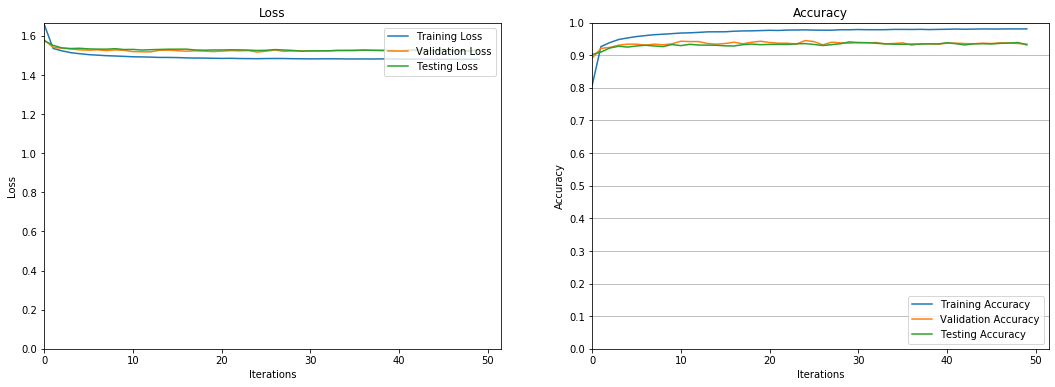

In [18]:
# callback to test after each epoch
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        self.test_acc = []
        self.test_loss = []

    def on_epoch_end(self, epoch, logs=None):
        # perform a test per epoch
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0, batch_size=32)
        self.test_loss.append(loss)
        self.test_acc.append(acc)
        # append to returned dictionary
        logs["test_loss"] = self.test_loss
        logs["test_acc"] = self.test_acc


# train
history = model.fit(trainData, train_labels, 
                    validation_data=(validData, valid_labels),
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[TestCallback((testData, test_labels))],
                    verbose=0,  # 0 = silent, 1 = per epoch 
                    shuffle=True)

# print(history.history)

# plot accuracy + loss
train_acc = history.history["acc"]
val_acc = history.history["val_acc"]
test_acc = history.history["test_acc"][0]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
test_loss = history.history["test_loss"][0]

statistics = (train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
display_statistics(*statistics)

### 2.3 Hyperparameter Investigation {-}


L2 Normalization with 0.01

Training loss: 1.5345		Training acc: 96.86%
Validation loss: 1.5678	Validation acc: 93.5%
Testing loss: 1.569	Testing acc: 93.5%


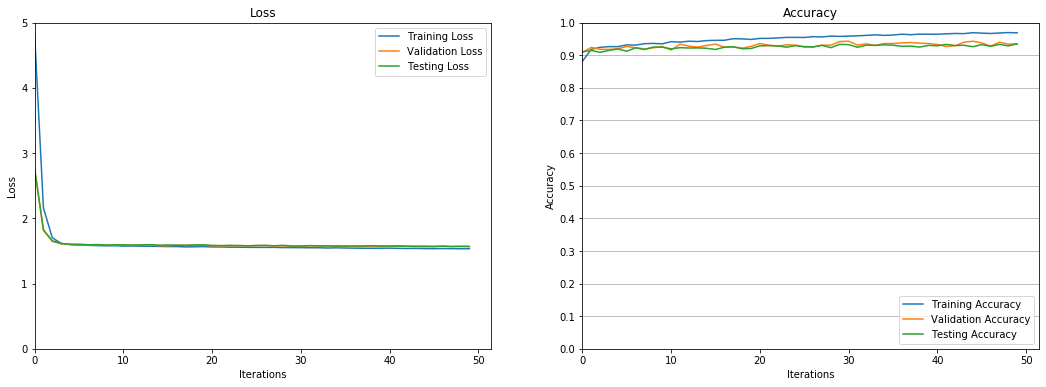


L2 Normalization with 0.1

Training loss: 1.6037		Training acc: 92.97%
Validation loss: 1.6036	Validation acc: 92.7%
Testing loss: 1.6122	Testing acc: 91.7%


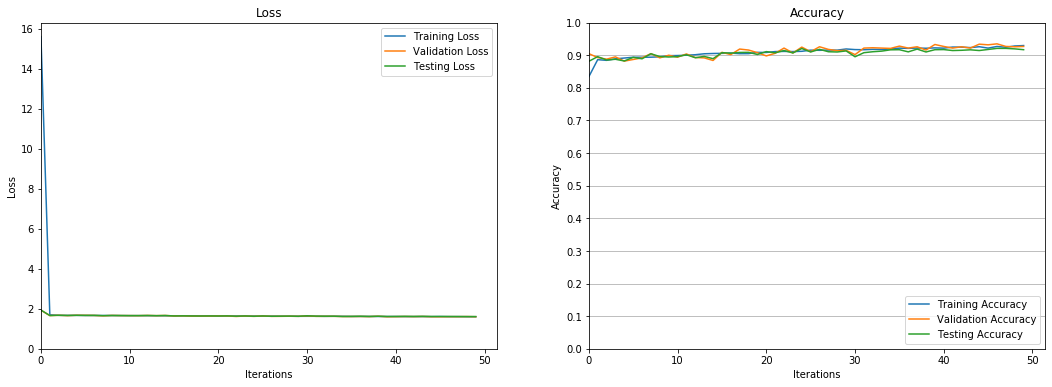


L2 Normalization with 0.5

Training loss: 1.6725		Training acc: 90.21%
Validation loss: 1.6759	Validation acc: 90.0%
Testing loss: 1.6763	Testing acc: 90.01%


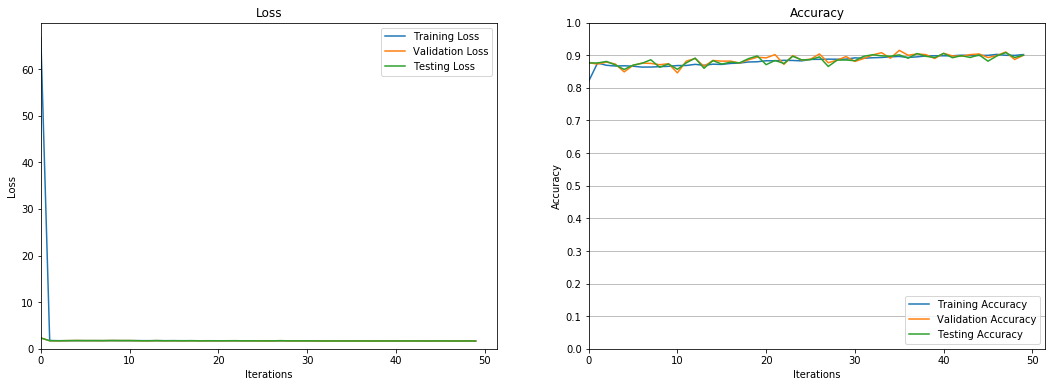

In [20]:
# 2.3.1: L2 Regularization

# training params
learning_rate = 0.0001
epochs = 50
batch_size = 32

# test all weight decays [0.01, 0.1, 0.5]
for scale in [0.01, 0.1, 0.5]:
    print("\nL2 Normalization with {}\n".format(scale))

    # create model
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(28, 28,1)))    # input layer
    model.add(layers.Conv2D(                                                        # conv layer
          filters=32,
          strides=(1,1),
          kernel_size=[3, 3],
          padding="same",
          activation='relu',
          kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)))
    model.add(layers.BatchNormalization())                                          # batch norm
    model.add(layers.MaxPooling2D((2, 2)))                                          # max pooling
    model.add(layers.Flatten())                                                     # flatten
    model.add(layers.Dense(784, 
                        activation='relu',
                        kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=scale)))  # fully-connected 784 w/ ReLu
    model.add(layers.Dense(10))                                                     # fully-connected 10
    model.add(layers.Softmax())                                                     # softmax output

    # compile model w/ Adam optimizer + cross entropy loss
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    # train
    history_1 = model.fit(trainData, train_labels, 
                      validation_data = (validData, valid_labels),
                      epochs=epochs, 
                      batch_size=batch_size,
                      callbacks=[TestCallback((testData, test_labels))],
                      verbose=0,  # 0 = silent, 1 = per epoch 
                      shuffle=True)
    # display stats
    train_acc = history_1.history["acc"]
    val_acc = history_1.history["val_acc"]
    test_acc = history_1.history["test_acc"][0]
    train_loss = history_1.history["loss"]
    val_loss = history_1.history["val_loss"]
    test_loss = history_1.history["test_loss"][0]

    statistics = (train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
    display_statistics(*statistics)

**General Comments**: L2 regularization is a technique to reduce overfitting. For small values of $\lambda$, we expect a slight improvement in model performance and a reduced discrepancy between training and validation/test accuracies. This is exactly what we observe here. For $\lambda = 0.01$, we observe validation and testing accuracy both improve slightly while training accuracy decreases by $\sim 1.5\%$. So, the model performance improves slightly and the model overfits less as expected. For values of $\lambda$ that are too large, we expect the model to start underfitting as we are harshly penalizing parameter vectors which are large in magnitude. As $\lambda$ increases, we see the discrepancy between training and validation/test accuracies decrease dramatically (the model is no longer overfitting). However, this change is accompanied by a reduction in overall accuracy (by $\sim 2 \%$) as the model is now underfitting.


Dropout with probability  0.90

Training loss: 1.484		Training acc: 97.71%
Validation loss: 1.5219	Validation acc: 93.9%
Testing loss: 1.5291	Testing acc: 93.14%


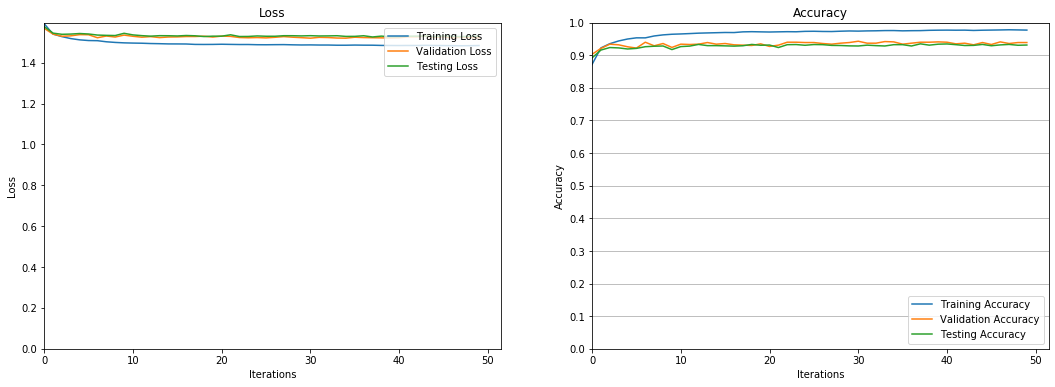


Dropout with probability  0.75

Training loss: 1.4808		Training acc: 98.04%
Validation loss: 1.5174	Validation acc: 94.4%
Testing loss: 1.5249	Testing acc: 93.5%


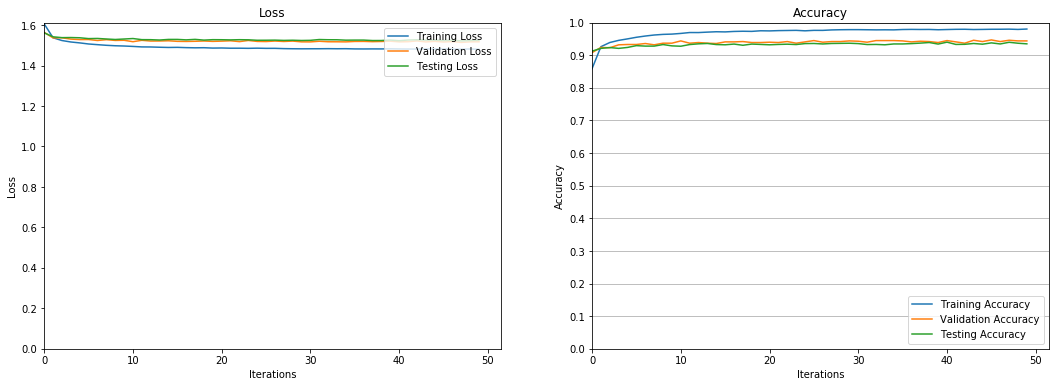


Dropout with probability  0.50

Training loss: 1.4788		Training acc: 98.25%
Validation loss: 1.5178	Validation acc: 94.4%
Testing loss: 1.523	Testing acc: 93.91%


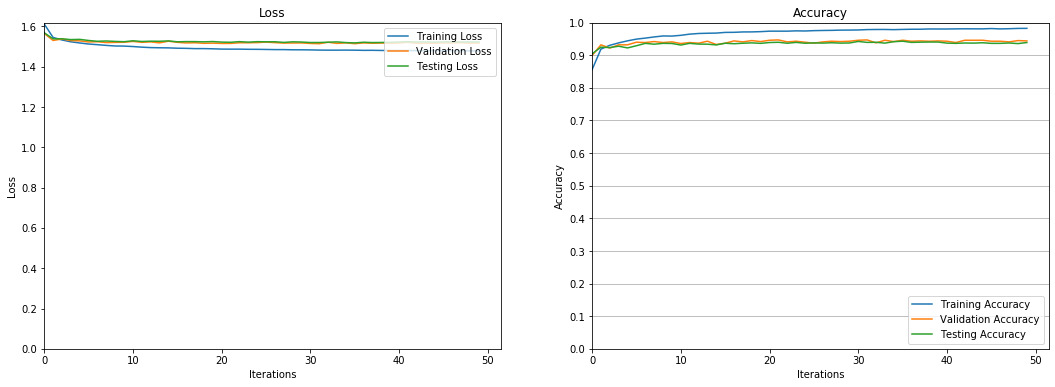

In [21]:
# 2.3.2: Dropout

# training params
learning_rate = 0.0001
epochs = 50
batch_size = 32

# for rate in [0.9, 0.75, 0.5]:
for rate in [0.1, 0.25, 0.5]:
    print("\nDropout with probability {printed: .2f}\n".format(printed=1-rate))

    # create model
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(28, 28,1)))    # input layer
    model.add(layers.Conv2D(                                                        # conv layer
          filters=32,
          strides=(1,1),
          kernel_size=[3, 3],
          padding="same",
          activation='relu',
          kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False)))
    model.add(layers.BatchNormalization())                                          # batch norm
    model.add(layers.MaxPooling2D((2, 2)))                                          # max pooling
    model.add(layers.Flatten())                                                     # flatten
    model.add(layers.Dense(784))                                                    # fully-connected 784 w/ ReLu
    model.add(layers.Dropout(rate=rate))                                            # dropout
    model.add(layers.ReLU())                                                         # Relu activation
    model.add(layers.Dense(10))                                                     # fully-connected 10
    model.add(layers.Softmax())                                                     # softmax output

    # compile model w/ Adam optimizer + cross entropy loss
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    # train
    history_2 = model.fit(trainData, train_labels, 
                      validation_data = (validData, valid_labels),
                      epochs=epochs, 
                      batch_size=batch_size,
                      callbacks=[TestCallback((testData, test_labels))],
                      verbose=0,  # 0 = silent, 1 = per epoch 
                      shuffle=True)
    # display stats
    train_acc = history_2.history["acc"]
    val_acc = history_2.history["val_acc"]
    test_acc = history_2.history["test_acc"][0]
    train_loss = history_2.history["loss"]
    val_loss = history_2.history["val_loss"]
    test_loss = history_2.history["test_loss"][0]

    statistics = (train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
    display_statistics(*statistics)

**General Comments**: Dropout is a technique which aims to decrease overfitting in our model. We expect see this in the form of improved accuracy and loss statistics. Indeed, this is exactly observed. As the amount of dropout increases (keeping the rate within reason), the validation and testing accuracies both improve. Note that we also see training accuracy improve. So, it seems that the model as an increased capacity to learn overall. With dropout, it is able to learn the training data better, but it is also able to generalize better.